# Estimation of the Mean Function of Functional Data via Deep Neural Networks

In [92]:
# nibabel documentation: https://nipy.org/nibabel/gettingstarted.html
# https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/#:~:text=The%20number%20of%20epochs%20is%20a%20hyperparameter%20that%20defines%20the,update%20the%20internal%20model%20parameters.

In [1]:
import glob
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import product
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Flatten, Dense, Dropout)
import nibabel as nib
from nibabel.testing import data_path

import pydot_ng
import pydot
import pydotplus
import graphviz
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', None)

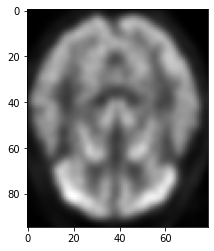

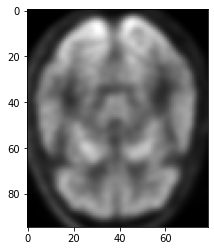

In [2]:
pixel_values_by_slice = list()
for file in glob.glob('images/ADNI_data/*.nii')[:2]:
    images = nib.load(file) #load the data
    data = images.get_fdata().T #transpose the original data - it should fit the format 95*79
    plt.imshow((data[20]), cmap='gray')
    plt.show()
    pixel_values_by_slice.append(data[20])
    mean_pixel_values = np.array(pixel_values_by_slice).mean(axis=0)

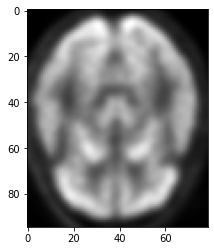

In [3]:
plt.imshow((mean_pixel_values), cmap='gray')
plt.show()

# Data definition
- There are 69 images slices contained in a 3D data cube.
- We use one slice from a given cube.
- When combining with other slices from other images we need to make sure that we select the slice from the same position inside the cube.
- Each image slice is a 95x79 matrix.
- Each row of the matrix is the output vector which needs to be predicted. These are the individual pixels in the image.
- To predict the output we need to generate the features which are the coordinates of each pixel in the output vector.
- The coordinates need to be normalized to 1 so for each coordinate needs to be divided by the $L_0$ norm of the vector.
    - Example: for the first pixel the coordinates will be $(\frac{1}{95},\frac{1}{79})$ and for the last pixel the coordinates will be $(\frac{1}{95}, \frac{79}{79})$
-------------------------------------------------------

# Model input and output
## Input: a set of coordinates e.g. $(\frac{1}{95},\frac{1}{79})$

### X:
- Get all the first coordinates as first column of the input matrix
- Get all the second coordinates as the second column of the input matrix
----------------------------------------------------------
## Output: predicted value for the pixel at that coordinate.

### Y:
- Take the matrix that contains the actual pixels for each image (this is the desired output) and ravel the array to get it into a single array of 95*79 elements each corresponding to the pixel value that needs to be predicted.
    - example: for an image with dimensions 95x79 - the total number of coordinate sets should be 95*79
    - the number of coordinates should be exactly the same as the number of pixels in the image - this will give a 1:1 correspondence between coordinates and pixels
    - even though as the image changes the pixels in the image change - the coordinates will remain the same for each pixel.

In [4]:
# %%writefile utils/preprocessing.py
import glob
import pandas as pd
import numpy as np
import nibabel as nib
from nibabel.testing import data_path
import matplotlib.pyplot as plt

def get_mean_pixel_values(data_location='images/ADNI_data/*.nii', img_slice=20, num_images_to_use='all', plot_image_slice=True, plot_mean_image_slice=True):
    """
    Take in images files. Combine the same slices and return mean pixel values.
    """
    pixel_values_by_slice = list()
    files = glob.glob(data_location)
    
    if num_images_to_use=='all':
        n = len(files)
    else:
        n = num_images_to_use
        
    for file in glob.glob(data_location)[:n]:
        images = nib.load(file) #load the data
        data = images.get_fdata().T #transpose the original data - it should fit the format 95*79
        if plot_image_slice:
            plt.imshow((data[img_slice]), cmap='gray')
            plt.title(file)
            plt.show()
        pixel_values_by_slice.append(data[img_slice])
    
    mean_pixel_values = np.array(pixel_values_by_slice).mean(axis=0)
    if plot_mean_image_slice:
        plt.imshow(mean_pixel_values, cmap='gray')
        plt.show()
    mean_pixel_values_flattened = mean_pixel_values.ravel()
    return mean_pixel_values, mean_pixel_values_flattened

def preprocess_image(data_location='images/ADNI_data/*.nii', img_slice=20, num_images_to_use='all', plot_image_slice=True, plot_mean_image_slice=True):
    """
    Input: 
        img: Image as nii file - data cube with slices for an image
        img_slice: integer to specify which slice to select
    Return 
        X: dataframe with two columns containing X and Y coordinates.
        Y: flattened pixel values
    """
    pixel_values, pixel_values_flattened = get_mean_pixel_values(plot_image_slice=False)
    
    # Y = data[img_slice].ravel() #flatten the matrix of pixels into a single array
    Y = pd.DataFrame(pixel_values_flattened, columns=['pixel_value']) #for the first image
    
    #get the number of rows and columns for the matrix of pixels per image
    rows = pixel_values.shape[0] #number of rows
    cols = pixel_values.shape[1] #number of columns

    #generate coordinates
    row_indices = list()
    column_indices = list()

    row_coordinates =  (np.indices(dimensions=(rows, cols))[0]+1)*(1/rows) #add 1 to avoid start from 0 - multiply by 1/cols to notmalize
    column_coordinates =  (np.indices(dimensions=(rows, cols))[1]+1)*(1/cols) #add 1 to avoid start from 0 - multiply by 1/cols to notmalize

    for row in row_coordinates:
        for row_index in row:
            row_indices.append(row_index)

    for row in column_coordinates:
        for column_index in row:
            column_indices.append(column_index)
            
    X = pd.DataFrame(columns=['X_coordinate', 'Y_coordinate'])
    X['X_coordinate'] = np.array(row_indices)
    X['Y_coordinate'] = np.array(column_indices)
    
    return X, Y

- Should coordinates and pixels values for all images be stacked and one combined dataset be created?

## Simple DNN

In [6]:
# %%writefile models/simple_dnn_model.py
import pandas as pd
import numpy as np
from itertools import product
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Flatten, BatchNormalization, Activation, Dense, Dropout)
import matplotlib.pyplot as plt

class Callback(tf.keras.callbacks.Callback):
    epoch_controller = 25

    def on_epoch_end(self, epoch, logs=None):
        self.epoch = epoch
        if (self.epoch%self.epoch_controller==0):
            print('Epoch: ' + str(self.epoch) + ' loss: ' + str(logs['loss']))
        
def simple_dnn_model(X_train, 
                        Y_train, 
                        neurons_per_layer=1000,
                        activation_per_layer='relu',
                        epochs=500,
                        batch_size=8,
                        verbose=0):
    """
    DNN with default RELU activation
    """        
    
    model = keras.models.Sequential([
        Flatten(input_shape=X_train.shape[1:]),
        Dense(neurons_per_layer),
        Activation(activation_per_layer),
        Dense(neurons_per_layer),
        Activation(activation_per_layer),
        # Dense(neurons_per_layer),
        # Activation(activation_per_layer),
        Dense(1)
    ])
            
    #define loss to minimize
    loss_to_minimize = tf.keras.losses.MeanSquaredError()
    
    #compile the model
    model.compile(loss=loss_to_minimize)
    
    #model fit
    model_history = model.fit(X_train, Y_train, 
                              batch_size=batch_size, 
                              epochs=epochs,  
                              callbacks=[Callback()], 
                              verbose=verbose)
    
    return model_history, model


def train_predict_simple_dnn_model(X, Y, **model_params):
    """
    Train and predict pixel values from the model
    """
    neurons_per_layer = model_params["neurons_per_layer"] if "neurons_per_layer" in model_params else 100
    activation_per_layer = model_params["activation_per_layer"] if "activation_per_layer" in model_params else "relu"
    epochs = model_params["epochs"] if "epochs" in model_params else 500
    batch_size = model_params["batch_size"] if "batch_size" in model_params else 8
    verbose = model_params["verbose"] if "verbose" in model_params else 0
    
    model_history, model = simple_dnn_model(X, Y,
                                     neurons_per_layer=neurons_per_layer,
                                     activation_per_layer=activation_per_layer, 
                                     epochs=epochs, 
                                     batch_size=batch_size,
                                     verbose=verbose)
    y_pred = model.predict(X)
    
    plt.imshow(np.reshape(y_pred, (95, 79)), cmap='gray') #display the recovered image
    
    return model_history, model, y_pred

Original Mean Image


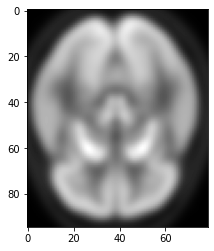

Epochs: 300, Activation: relu, Batch Size: 4
******************************
Epoch: 0 loss: 0.09383431077003479
Epoch: 25 loss: 0.014003108255565166
Epoch: 50 loss: 0.00869012251496315
Epoch: 75 loss: 0.0066453805193305016
Epoch: 100 loss: 0.005697447806596756
Epoch: 125 loss: 0.00494332006201148
Epoch: 150 loss: 0.0043620760552585125
Epoch: 175 loss: 0.004083027597516775
Epoch: 200 loss: 0.0038234596140682697
Epoch: 225 loss: 0.003527341177687049
Epoch: 250 loss: 0.003354277228936553
Epoch: 275 loss: 0.0031778740230947733
******************************
Epochs: 300, Activation: relu, Batch Size: 8
******************************
Epoch: 0 loss: 0.1093699187040329
Epoch: 25 loss: 0.013544237241148949
Epoch: 50 loss: 0.0077691515907645226
Epoch: 75 loss: 0.0058694519102573395
Epoch: 100 loss: 0.004763473756611347
Epoch: 125 loss: 0.003951382357627153
Epoch: 150 loss: 0.003436894854530692
Epoch: 175 loss: 0.002980708610266447
Epoch: 200 loss: 0.0027039595879614353
Epoch: 225 loss: 0.00247611

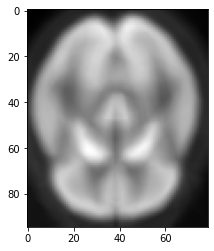

In [7]:
print('Original Mean Image')
X, Y = preprocess_image(data_location='images/ADNI_data/*.nii', img_slice=20, num_images_to_use='all', plot_image_slice=False, plot_mean_image_slice=True)

# run for 300, 500 epochs each with batch size 2, 4, 6, 8
model_histories = defaultdict()
predictions = defaultdict()
for num_epochs in [300, 500]:
    for batch_size in [4, 8]:
        model_params = {"neurons_per_layer": 1000,
                        "activation_per_layer": "relu",
                        "epochs": num_epochs,
                        "batch_size": batch_size,
                        "verbose": 0}

        print(f'Epochs: {model_params["epochs"]}, Activation: {model_params["activation_per_layer"]}, Batch Size: {model_params["batch_size"]}')
        
        print('*'*30)
        model_history, _ , y_pred = train_predict_simple_dnn_model(X, Y, **model_params)
        model_histories[f'{model_params["epochs"]}-{model_params["activation_per_layer"]}-{model_params["batch_size"]}'] = pd.DataFrame(model_history.history)
        predictions[f'{model_params["epochs"]}-{model_params["activation_per_layer"]}-{model_params["batch_size"]}'] = y_pred
        
        plt.imshow(np.reshape(y_pred, (95, 79)), cmap='gray') #display the recovered image
        plt.savefig(f'results/reconstructed_images/{model_params["epochs"]}-{model_params["activation_per_layer"]}-{model_params["batch_size"]}.png')
        print('*'*30)

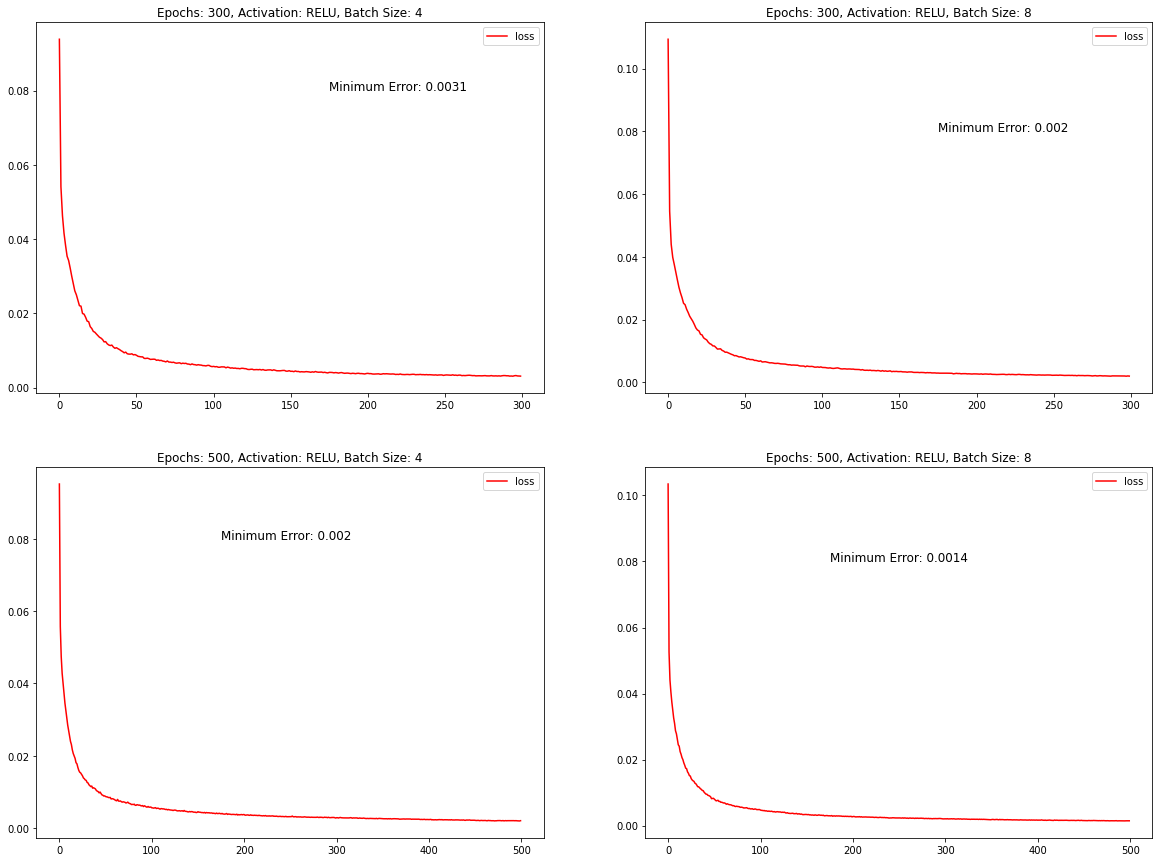

In [13]:
# keras.utils.plot_model(dnn_model)
iters = list(model_histories.keys())
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
for i, ax in zip(range(len(iters)), axs.ravel()):
    model_histories[iters[i]].plot(ax=ax, color='red')
    ax.text(175, 0.08, f'Minimum Error: {round(model_histories[iters[i]].min()[0],4)}', fontsize=12)
    ax.set_title(f'Epochs: {iters[i][:3]}, Activation: {iters[i][4:8].upper()}, Batch Size: {iters[i][9:]}')
    plt.savefig('results/simple_two_layer_dnn.png', facecolor='white')

0.0018